> 本篇介绍IEEE754浮点数，以及**浮点数和定点数的互相转换方法**（<font color =green >hardware implementation included</font>）

# IEEE754介绍  

下图就是32bit float的bit构成  

**[31]为S**    ：符号位，<u>0代表正数，1代表负数</u>   
**[30:23]为E** ：2为底数的exponent，使用**移码**表示，即<u>unsigned E所代表的值减去bias（这里是127）为真实的exponent(又叫**阶码真值**）</u>  
**[22:0]为M**  ：尾数，是原码。<u>实际代表的值是1.M</u>  

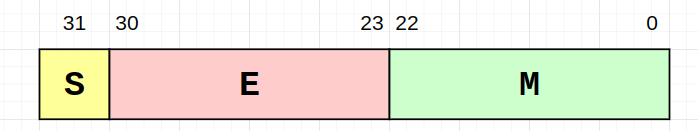

特别地，E=0和255时，E-127并不是用作常规的exponent，所以常规**阶码真值**为[-126,+127] 

- 当阶码真值=-127时：表示非规格小数，此时M实际应当是**0.M**而不是**1.M**,阶码真值固定为-126,因此当阶码全0而尾数全0,表示 **+/-0** 

- 当阶码真值=+128时：尾数全0表示 **+/-inf**，而尾数不全为0表示 **NaN**

可以得到常规的浮点表达公式
$$
(-1)^s \times 2^{e-127} \times 1.f
$$
我们在python中验证一下，使用struct.pack方法,将浮点转成字节,并运用以上公式

In [1]:
import struct
a = 3.1415926
a_bytes = struct.pack('!f',a)#大端格式
a_hex   = a_bytes.hex()
a_bin   = ''.join(f'{byte:08b}' for byte in a_bytes)
print(a_bytes,a_hex,a_bin)
s = a_bin[0]  # 符号位是第一个字符
e = a_bin[1:9]  # 指数位是接下来的8位
m = a_bin[9:32]  # 尾数位是剩下的23位
print('-'*50)
print('S\tE\t\tM\t')
print('{}\t{}\t{}'.format(s,e,m))
s = int(s,2)
e = int(e,2)-127
m = (1+(int(m,2)/2**23)) 
print('{}\t{}\t\t{}'.format(s,e,m))
print('-'*50)
result =    \
(-1)**s  *  \
2**e     *  \
m
print('\33[7;1m{}\33[0m'.format(result))

b'@I\x0f\xda' 40490fda 01000000010010010000111111011010
--------------------------------------------------
S	E		M	
0	10000000	10010010000111111011010
0	1		1.570796251296997
--------------------------------------------------
3.141592502593994


这里结果是3.141592**5**的原因是因为这是FP32本身的误差，可以把0x40490fda改成0x40490fdb，结果就是3.141592**7**

# 浮点转定点

软件侧其实可以使用`fixedpoint`库，但是因为我们需要考虑硬件实现，所以需要考虑更底层的转换方法  
定点数和浮点数的区别如下  
我们举例的定点数时9位整数位+7位小数位，当然定点数的规定是灵活的  
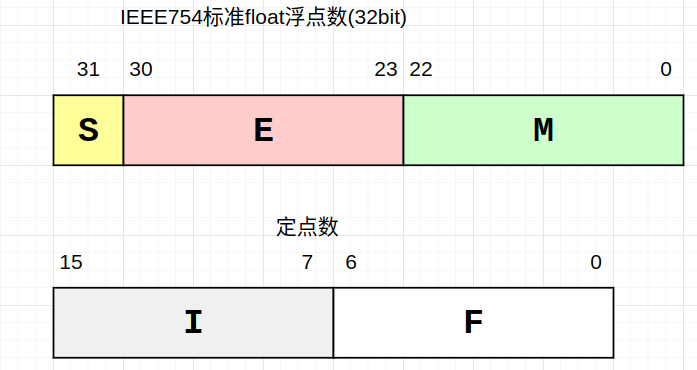

## 溢出判断（最高“1”位置确定）

首先，需要确定浮点数是否会溢出定点数的**表示范围**  
我们令定点数整数部分位宽为WOI，小数部分位宽为FOI
首先考虑，
$$
floatA = \pm (2)^{exp-127} \times \textcolor{red}{1}.f
$$
所以这个最高位的<font color=red>1</font>应当放在 第<font color=red>**<u>exp-127 + WOF</u>**</font>位，  
举例而言[1]，exp-127=0,代表结果1.f的这个1应当放在定点数的整数部分最低位(第WOF位)  
举例而言[2]，exp-127=2,代表结果1.f(<<2)的这个1应当放在定点数的第WOF+2位

结论：  
**<font color=a83022> exp-127+WOF >= WOI+WOF-1</font> 时应当报overflow** (因为这里定点最高为是补码符号位，不能将浮点最高1放在定点最高位)  
**此外，<font color=a83022> exp为全1</font>也要报overflow** ，因为是inf或NaN(但是如果保证不会发生就可以省略掉)  
<u>同时我们顺带把0也排除掉</u>，浮点全0代表为0,我们不做任何操作，因为定点初始化就是全0  
继续拿3.1415926作例子，来判断一下是否溢出


In [2]:
import struct
WOI = 9
WOF = 7
a = 3.1415926
a_bytes = struct.pack('!f',a)#大端格式
a_hex   = a_bytes.hex()
a_bin   = ''.join(f'{byte:08b}' for byte in a_bytes)
e_bin = a_bin[1:9] 
e = int(e_bin,2) 
print('exp-127+WOF:\t{}'.format(e-127+WOF))
print('WOI+WOF-1:\t{}'.format(WOI+WOF-1))
print('-'*50)
print('\33[7;1moverflow?\33[0m\t\33[7;1m{}\33[0m'.format((e-127+WOF) >= (WOI+WOF-1)))

exp-127+WOF:	8
WOI+WOF-1:	15
--------------------------------------------------
overflow?	False


## 从高到低放置

OK,没有溢出，那我们接下来只需要从高位1开始，按次序把1都对应放置即可，如图所示  
最高位1放在<font color=red>**第8位**</font>（如上面python计算所得）  
M=1.10010010000111111011010  
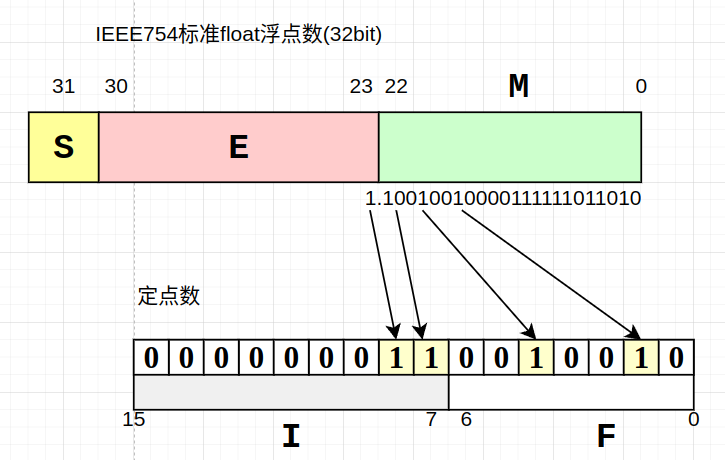  
用代码实现如下

In [3]:
import struct
WOI = 9
WOF = 7
a = 3.1415926
a_bytes = struct.pack('!f',a)#大端格式
a_hex   = a_bytes.hex()
a_bin   = ''.join(f'{byte:08b}' for byte in a_bytes)
e_bin = a_bin[1:9] 
m_bin = '1'+ a_bin[9:32]  
e = int(e_bin,2) 

start_bit = e-127+WOF#确定最高位1的放置位置

####################################
###need to add round in next part
####################################
fix_result = "0"*(WOI+WOF-start_bit-1) + m_bin [0:start_bit+1]#本例中后面截断，在下一节会展示round操作
print('-'*50)
print('MSB'+' '*(WOI+WOF-6)+'LSB')
print('\33[7;1m{}\33[0m'.format(fix_result))
print('-'*50)
print(int(fix_result,2)/2**WOF)#int要求二进制字符串左侧是MSB

--------------------------------------------------
MSB          LSB
0000000110010010
--------------------------------------------------
3.140625


如上，得到了浮点转定点的十进制结果
在本例中，并没有提到round操作，我们把放不下的一丢弃了（如下图）  
实际上，还需要进行round操作保证准确性  
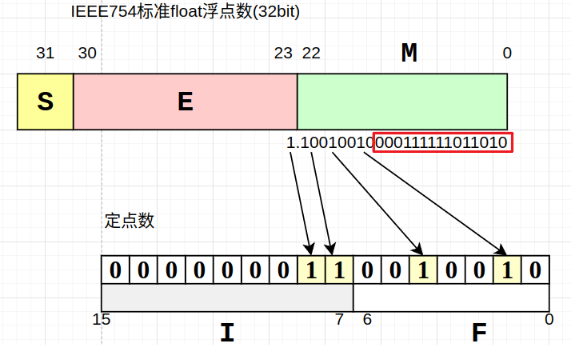

## round操作

round操作在数字系统中使用的很多（<I>当时在巴龙的暑期实习就遇到过计算核以及验证rm中需要进行round操作</I>）  
可以参考[fixedpoint库关于round的叙述](https://fixedpoint.readthedocs.io/en/latest/initialization.html?highlight=round#rounding)  
convergent舍入，又称为银行家舍入，又称为像偶数舍入，即当遇到5舍入的时候，向着偶数舍入，其余情况都是朝着最近舍入（在二进制情况下就是0偶数1奇数） 
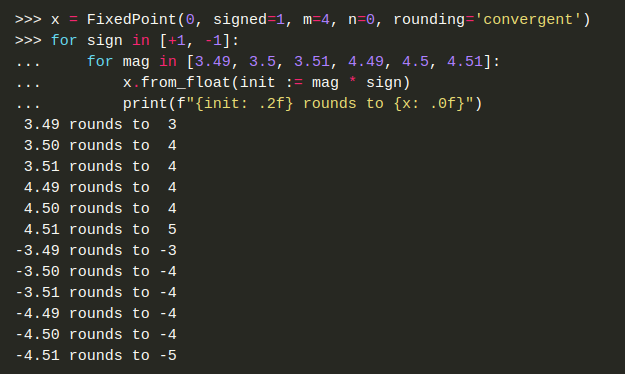  
python的round库就是用的这种舍入方法  
另一种常见的是向正无穷大舍入  
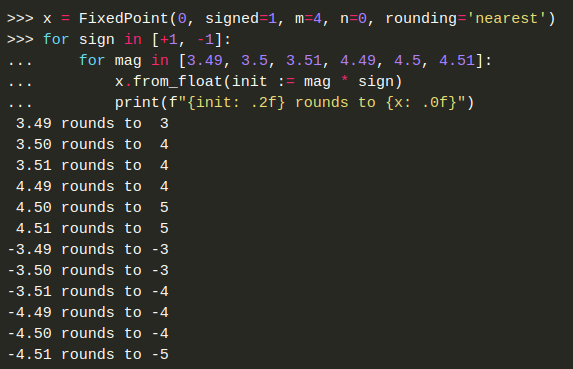  
此外，还有round away from 0 等方式  
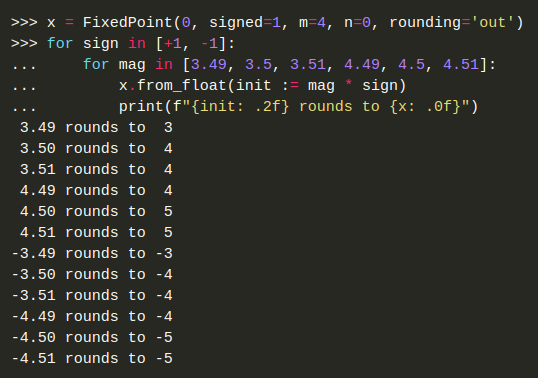  
目前我们采用硬件实现比较方便的舍入方式，即round away from 0  
因为遇到0就直接舍，遇到1直接+1,在符号上也是对称的  
参考的这篇代码用的就是这种方式
但是皮特派在视频中说，采用直接舍去的方式，因为四舍五入不如再增加一个bit分辨率来的有效  
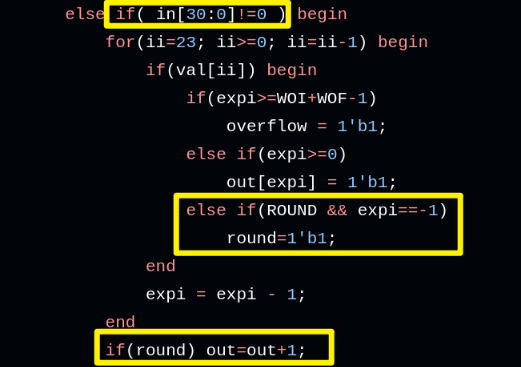   
在这种算法下，可以看到上一节的例子中，放不下的那一位是0,所以最后一位不需要进位  
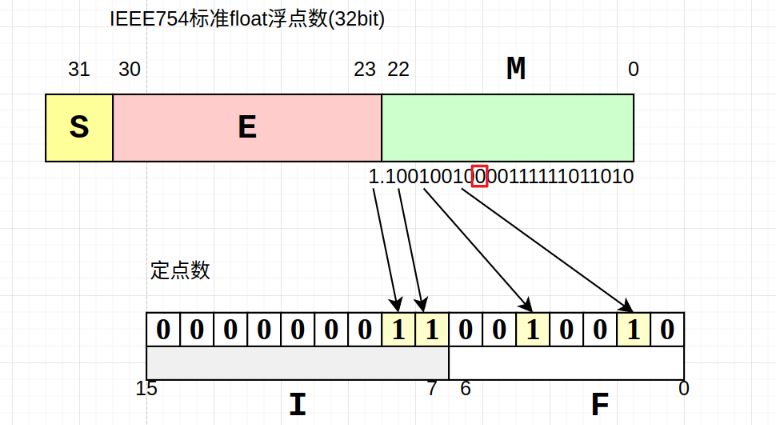  




# verilog实现

参卡代码在[这里](https://github.com/WangXuan95/FPGA-FixedPoint/blob/master/RTL/fixedpoint.v)  
给了非pipeline版本的和pipeline版本的，pipeline版本的时序收敛更好  